# Function appproximation

## Taylor approximation
We'll first show how you can use cicada for evaluating function approximations for any callable function in python. We generate coefficients for the approximating polynomials on the fly then use Cicada to evaluate the result of evaluating the approximated function on the secret shared argument. 

The first function we'll demonstrate is for hyperbolic tangent as this is a useful and common activation function for machine learning applications.

mean error: -3205.3109748840334, stdev error: 482009.74289776623


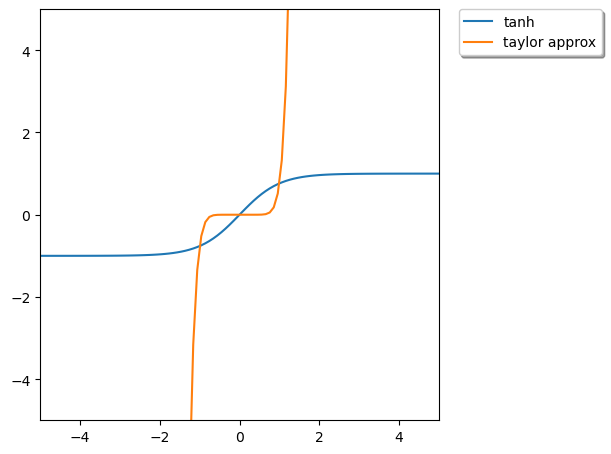

In [9]:
import logging

import numpy

import cicada
from cicada.additive import AdditiveProtocolSuite
from cicada.communicator import SocketCommunicator

from statistics import mean, stdev
from tqdm import *

logging.basicConfig(level=logging.INFO)


import matplotlib.pyplot as plt

func2try = numpy.tanh
def main(communicator):
    log = cicada.Logger(logging.getLogger(), communicator)
    protocol = AdditiveProtocolSuite(communicator)


    err_list = []
    
    axis = numpy.linspace(-5, 5, num=100)
    plt.plot(axis, func2try(axis), label="tanh")
    
    logging.basicConfig(level=logging.INFO)
    pade_evals=[]
    for x in axis:
        pade_evals.append(protocol.reveal(protocol.taylor_approx(func2try, protocol.share(src=0, secret=numpy.array(x), shape=()), degree=10)))
        legit = func2try(x)
        err_list.append(legit-pade_evals[-1])
        #if communicator.rank ==1:
        #    print(x, legit, pade_evals[-1], legit-pade_evals[-1])
    

    
    if communicator.rank ==1:
        print(f"mean error: {mean(err_list)}, stdev error: {stdev(err_list)}")
                    
    plt.plot(axis, pade_evals, label='taylor approx' )
                               
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0.0, shadow=True)
    plt.tight_layout()
    plt.axis([-5, 5, -5, 5])
    if communicator.rank == 1:
        plt.show()



SocketCommunicator.run(world_size=5, fn=main);

As you can see from the mean error, standard deviation, and plot, it's "ok" for operands near the center of the function's approximation range (0, by default) though it is decidedly non-awesome, and diverges to positive and negative infinity when the operand gets too far from the point at which the approximation was centered. This is a common and known behavior of Taylor approximation methods. We have also implemented another approximation method which has better/more stable behavior.

## Padé approximation
Testing for numpy tanh

mean error: 0.009981689453124986, error stdev: 0.6171436165930927


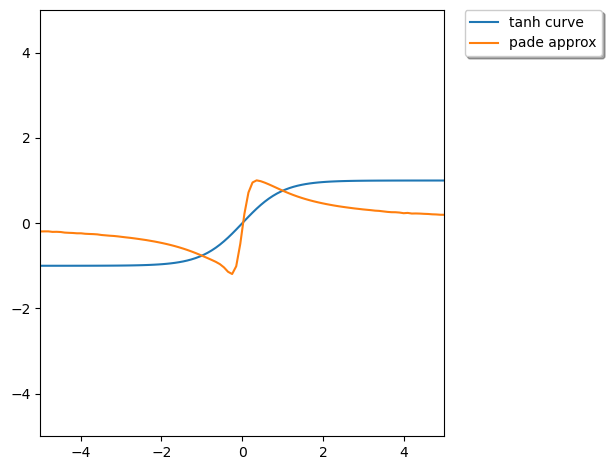

In [6]:
import logging

import numpy

import cicada
from cicada.additive import AdditiveProtocolSuite
from cicada.communicator import SocketCommunicator

from statistics import mean, stdev
from tqdm import *

import matplotlib.pyplot as plt

func2try = numpy.tanh

def main(communicator):
    log = cicada.Logger(logging.getLogger(), communicator)
    protocol = AdditiveProtocolSuite(communicator)

    err_list = []
    
    axis = numpy.linspace(-5.0, 5.0, num=100)
    plt.plot(axis, numpy.tanh(axis), label="tanh curve")
    
    logging.basicConfig(level=logging.INFO)
    pade_evals=[]
    for x in axis:
        pade_evals.append(protocol.reveal(protocol.pade_approx(func2try, protocol.share(src=0, secret=numpy.array(x), shape=()), scale=3, degree=12)))
        legit = func2try(x)
        err_list.append(legit-pade_evals[-1])
        #if communicator.rank ==1:
        #    print(x, legit, pade_evals[-1], legit-pade_evals[-1])
    

    
    if communicator.rank ==1:
        print(f"mean error: {mean(err_list)}, error stdev: {stdev(err_list)}")
                    
    plt.plot(axis, pade_evals, label='pade approx' )
                               
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0.0, shadow=True)
    plt.tight_layout()
    plt.axis([-5, 5, -5, 5])
    plt.show()


SocketCommunicator.run(world_size=5, fn=main);

Clearly the process isn't perfect, but it is a MUCH better approximation when compared with the Taylor series, and has the nice attribute of not diverging to positive or negative infinity

Next we'll show how you can do a similar thing on a user defined function, in this case, we'll define our own sigmoid:


mean error: -0.008994140625000008, error stdev: 0.33950291575106484


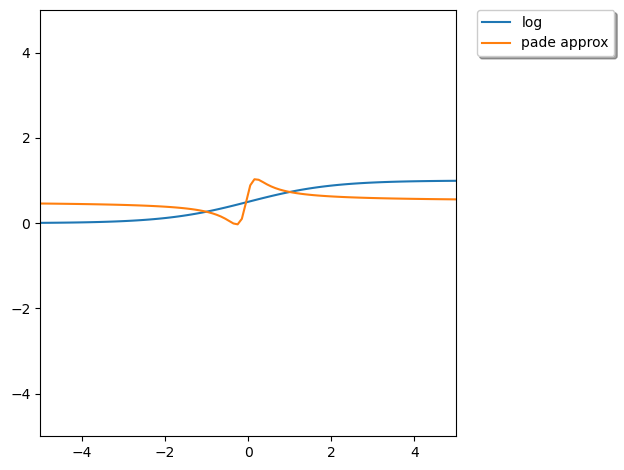

In [10]:
def sigmoid(X):
   return 1/(1+numpy.exp(-X))

import logging

import numpy

import cicada
from cicada.additive import AdditiveProtocolSuite
from cicada.communicator import SocketCommunicator

from statistics import mean, stdev
from tqdm import *

import matplotlib.pyplot as plt



func2try = sigmoid
def main(communicator):
    log = cicada.Logger(logging.getLogger(), communicator)
    protocol = AdditiveProtocolSuite(communicator)

    err_list = []
    
    axis = numpy.linspace(-5, 5, num=100)
    plt.plot(axis, func2try(axis), label="log")
    
    logging.basicConfig(level=logging.INFO)
    pade_evals=[]
    for x in axis:
        pade_evals.append(protocol.reveal(protocol.pade_approx(func2try, protocol.share(src=0, secret=numpy.array(x), shape=()), scale=3, degree=4)))
        legit = func2try(x)
        err_list.append(legit-pade_evals[-1])
        #if communicator.rank ==1:
        #    print(legit_tanh, cic_pade_tanh, legit_tanh-cic_pade_tanh)
    

    
    if communicator.rank ==1:
        print(f"mean error: {mean(err_list)}, error stdev: {stdev(err_list)}")
                    
    plt.plot(axis, pade_evals, label='pade approx' )
                               
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0.0, shadow=True)
    plt.tight_layout()
    plt.axis([-5, 5, -5, 5])
    if communicator.rank == 1:
        plt.show()


SocketCommunicator.run(world_size=3, fn=main);

That works about as well as was the case for hyperbolic tangent. This isn't a guaranteed-to-work process for all functions though. It is necessary to do a sanity check on the process prior to just throwing it in cicada because there can be unexpected results. This is due to the limiations of the approximation methods, nothing inherent to their use in cicada. Check the following example for a function that behaves poorly under these approximation methods, relu. 

mean error: 0.7601094779582939, error stdev: 2.012663412527922


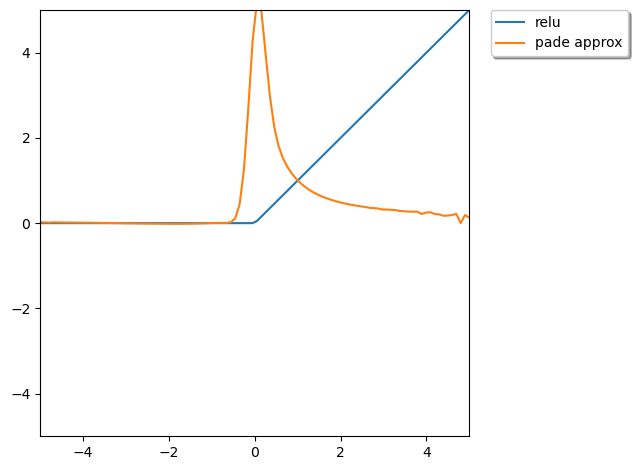

In [4]:
def relu(X):
   return numpy.maximum(0,X)

import logging

import numpy

import cicada
from cicada.additive import AdditiveProtocolSuite
from cicada.communicator import SocketCommunicator

from statistics import mean, stdev
from tqdm import *

import matplotlib.pyplot as plt



func2try = relu
def main(communicator):
    log = cicada.Logger(logging.getLogger(), communicator)
    protocol = AdditiveProtocolSuite(communicator)

    err_list = []
    
    axis = numpy.linspace(-5, 5, num=100)
    plt.plot(axis, func2try(axis), label="relu")
    
    logging.basicConfig(level=logging.INFO)
    pade_evals=[]
    for x in axis:
        pade_evals.append(protocol.reveal(protocol.pade_approx(func2try, protocol.share(src=0, secret=numpy.array(x), shape=()), scale=3, degree=14)))
        legit = func2try(x)
        err_list.append(legit-pade_evals[-1])
        #if communicator.rank ==1:
        #    print(legit_tanh, cic_pade_tanh, legit_tanh-cic_pade_tanh)
    

    
    if communicator.rank ==1:
        print(f"mean error: {mean(err_list)}, error stdev: {stdev(err_list)}")
                    
    plt.plot(axis, pade_evals, label='pade approx' )
                               
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0.0, shadow=True)
    plt.tight_layout()
    plt.axis([-5, 5, -5, 5])
    if communicator.rank == 1:
        plt.show()


SocketCommunicator.run(world_size=3, fn=main);